In [1]:
%matplotlib inline
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as spec
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import sklearn.cluster
import sklearn.decomposition

In [3]:
N_docs = 100
N_words = 450
num_topics = 9
corpus = np.zeros((N_docs, N_words))  # shape (docs, words)
vocabulary = np.arange(N_words)

block = 10 * np.ones((20, 50))
for i in range(num_topics):
    corpus[10*i:10*(i+2),50*i:50*(i+1)] = block

np.random.seed(0)
shuff = np.random.choice(100, 100, replace=False)
corpus_shuffled = corpus[shuff,:]

In [69]:
nmf = sklearn.decomposition.NMF(9)

In [70]:
nmf.fit(corpus)

NMF(beta=1, eta=0.1, init=None, max_iter=200, n_components=9,
  nls_max_iter=2000, random_state=None, sparseness=None, tol=0.0001)

In [6]:
nmf.components_.shape

(9, 450)

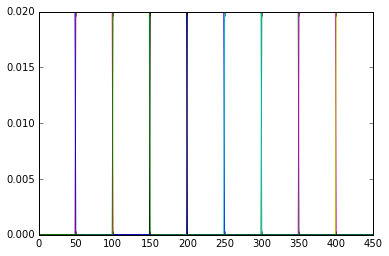

In [9]:
for i in range(9):
    plt.plot(range(450),nmf.components_[i,:]/sum(nmf.components_[i,:]))
plt.show()

In [74]:
nmf_shuffled = sklearn.decomposition.NMF(9,max_iter=2000)

In [75]:
nmf_shuffled.fit(corpus_shuffled)

NMF(beta=1, eta=0.1, init=None, max_iter=2000, n_components=9,
  nls_max_iter=2000, random_state=None, sparseness=None, tol=0.0001)

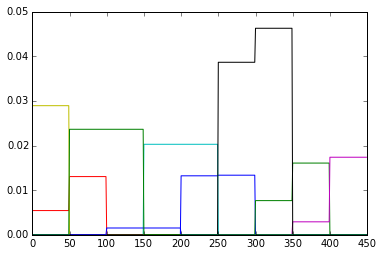

In [55]:
for i in range(9):
    plt.plot(range(450),nmf_shuffled.components_[i,:]/sum(nmf.components_[i,:]))
plt.show()

In [24]:
def rho(tau,kappa,t):
    return (tau+t)**(-kappa)

def digamma(mat):
    if (len(mat.shape) == 1):
        return(spec.psi(mat) - spec.psi(np.sum(mat)))
    else:
        return(spec.psi(mat) - spec.psi(np.sum(mat, 0))[np.newaxis,:])

In [46]:
def lda_minibatch_ordering(dtm,ntopic,mb_size,tau,kappa,itemax,start = False,lambda_ = None):
    nvoc = dtm.shape[1]
    ndoc = dtm.shape[0]
    nu = 1./ndoc
    alpha = 1./ndoc
    
    topics = np.random.gamma(100.,1./100.,(nvoc,ntopic))
    if start:
        topics = lambda_ 
    phi = np.random.gamma(100.,1./100.,(nvoc,ntopic))
    gamma  = np.random.gamma(100.,1./100.,(ndoc,ntopic))
    
    intint = 100
    idx = range(ndoc)
    minibatchesids = np.array_split(idx,len(idx)/mb_size)

    for it in range(itemax):
        topics_temp = np.zeros(topics.shape)
        indices = []
        for t in range(len(minibatchesids)):
            for id_ in minibatchesids[t]:
                doc = idx[id_]
                ids = np.nonzero(dtm[doc,:])[0]
                indices.extend(ids)
                cts = dtm[doc,ids]
                gamma_ = gamma[doc,:]
                Elogbeta = np.apply_along_axis(digamma, axis=0, arr=topics)[ids,:]
                dott = lambda x: np.dot(x,cts)
                
                for tt in range(intint):
                    old_gamma_ = gamma_
                    Elogtheta = digamma(gamma_)
                    E_sum = Elogbeta + Elogtheta
                    phi = np.exp(E_sum)/np.exp(E_sum).sum(axis=1)[:, np.newaxis]
                    gamma_ = alpha + np.apply_along_axis(dott,axis=0,arr=phi)
                    if np.sqrt(np.mean((gamma_-old_gamma_)**2))<0.000001:
                        break  
                gamma[doc,:] = gamma_
                topics_temp[ids,:] += phi * dtm[doc,ids][:, np.newaxis]
            
        indices  = np.unique(indices)
        topics_temp[indices,:] = nu + (ndoc/len(minibatchesids[t])) * topics_temp[indices,:]
        rt = rho(tau,kappa,it)
        topics[indices ,:] = (1-rt)*topics[indices,:] + rt*topics_temp[indices,:]

        if it % 10 == 0:
            sorted_model  = sklearn.cluster.KMeans(n_clusters  = ntopic)
            sorted_index = np.argsort(sorted_model.fit_predict(gamma))
            minibatchesids = np.array_split(sorted_index,len(sorted_index)/mb_size)

    return topics,gamma

In [73]:
def lda_minibatch(dtm,ntopic,mb_size,tau,kappa,itemax,start = False,lambda_ = None):
    nvoc = dtm.shape[1]
    ndoc = dtm.shape[0]
    nu = 1./ndoc
    alpha = 1./ndoc
    
    topics = np.random.gamma(100.,1./100.,(nvoc,ntopic))
    if start:
        topics = lambda_.copy() + nu
    phi = np.random.gamma(100.,1./100.,(nvoc,ntopic))
    gamma  = np.random.gamma(100.,1./100.,(ndoc,ntopic))
    
    intint = 100
    idx = range(ndoc)
    #np.random.shuffle(idx)
    idx *= itemax
    #np.random.shuffle(idx)
    minibatchesids = np.array_split(idx,len(idx)/mb_size)
    
    for t in range(len(minibatchesids)):
        topics_temp = np.zeros(topics.shape)
        indices = []
        
        for id_ in minibatchesids[t]:
            doc = idx[id_]
            ids = np.nonzero(dtm[doc,:])[0]
            indices.extend(ids)
            cts = dtm[doc,ids]
            gamma_ = gamma[doc,:]
            Elogbeta = np.apply_along_axis(digamma, axis=0, arr=topics)[ids,:]
            dott = lambda x: np.dot(x,cts)
            
            for tt in range(intint):
                old_gamma_ = gamma_
                Elogtheta = digamma(gamma_)
                E_sum = Elogbeta + Elogtheta
                phi = np.exp(E_sum)/np.exp(E_sum).sum(axis=1)[:, np.newaxis]
                gamma_ = alpha + np.apply_along_axis(dott,axis=0,arr=phi)
                if np.sqrt(np.mean((gamma_-old_gamma_)**2))<0.000001:
                    break  
            gamma[doc,:] = gamma_
            topics_temp[ids,:] += phi * dtm[doc,ids][:, np.newaxis]
            
        indices  = np.unique(indices)
        topics_temp[indices,:] = nu + (ndoc/len(minibatchesids[t])) * topics_temp[indices,:]
        rt = rho(tau,kappa,t)
        topics[indices ,:] = (1-rt)*topics[indices,:] + rt*topics_temp[indices,:]
    
    return topics,gamma,tau,kappa

In [124]:
def show_topics(lda,whichtopic,topwords,wordlist):
    topics = lda[0]
    for t in whichtopic:
        idx = np.argsort(topics[:,t])[::-1][:topwords].astype(int)
        words = []
        for i in idx:
            words.append(wordlist[i])
        print "Topic %s:" % t
        print ""
        print words
        print ""

In [41]:
np.random.seed(10)
test = lda_minibatch_ordering(corpus_shuffled,9,10,1,0.6,100)

In [77]:
np.random.seed(10)
test2 = lda_minibatch(corpus_shuffled,12,10,1,0.6,100)

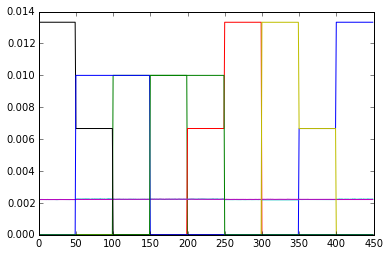

In [79]:
for i in range(9):
    plt.plot(range(450),test[0][:,i]/sum(test[0][:,i]))
plt.show()

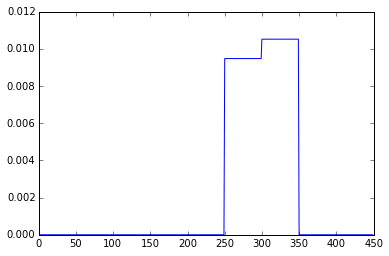

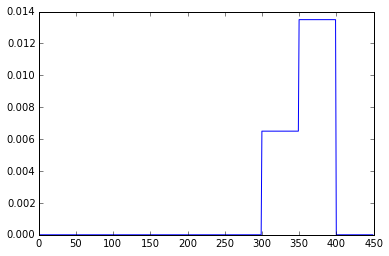

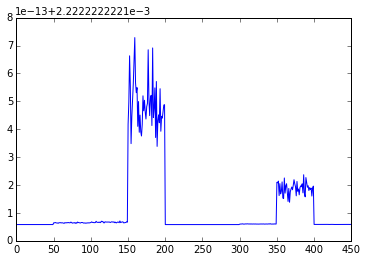

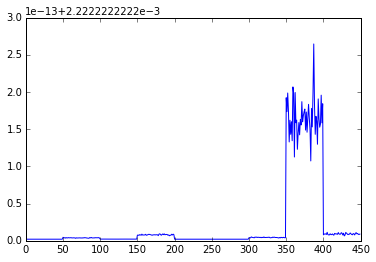

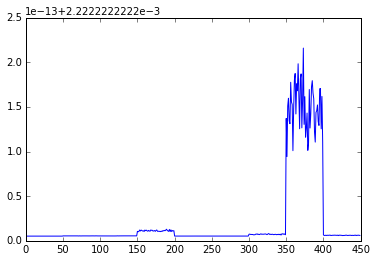

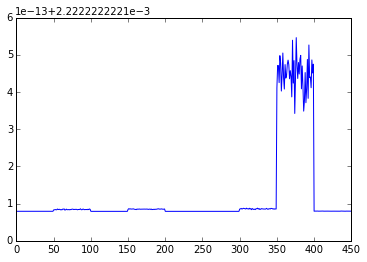

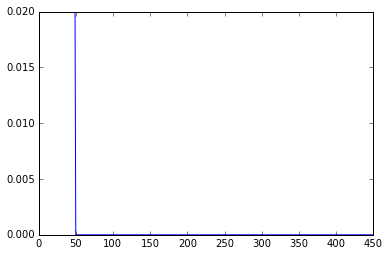

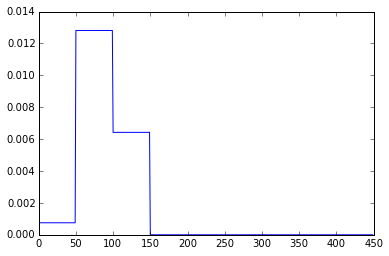

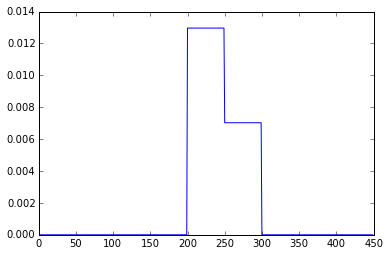

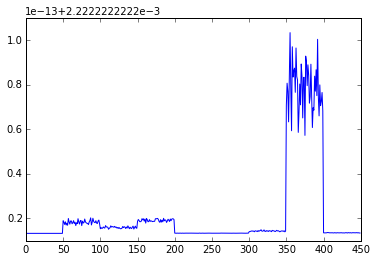

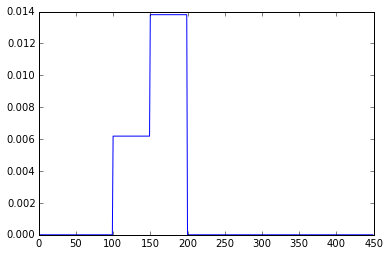

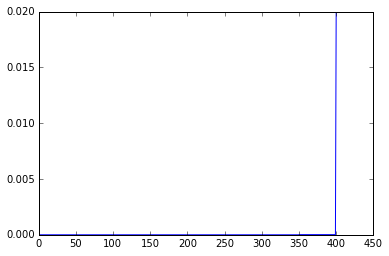

In [81]:
for i in range(12):
    plt.plot(range(450),test2[0][:,i]/sum(test2[0][:,i]))
    plt.show()

In [76]:
test3 = lda_minibatch(corpus_shuffled,9,10,1,0.6,100,True,copy)

KeyboardInterrupt: 

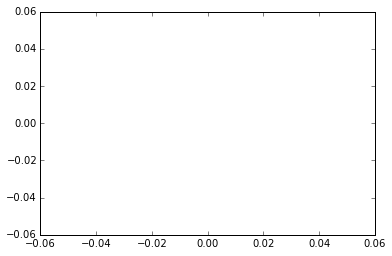

In [58]:
for i in range(9):
    plt.plot(range(450),test3[0][:,i]/sum(test3[0][:,i]))
plt.show()

In [65]:
copy = nmf_shuffled.components_.T

In [67]:
copy

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

In [72]:
copy

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

In [82]:
import json
with open('CS281/temp/edinburgh_word_adjective.json', 'r') as fp:
    edi = json.load(fp)

In [85]:
r0 = edi.keys()[0]

In [86]:
vocab = []
for i in edi.keys():
    vocab.extend(edi[i][0][0])

In [94]:
import collections
collections.Counter(vocab)

7344

In [103]:
vocab10 = []
d = collections.Counter(vocab)
for w in vocab:
    if d[w]>=10:
        vocab10.append(w)

In [99]:
len(vocab)

264343

In [100]:
len(vocab5)

241802

In [105]:
vocab10 = list(set(vocab10)) 

In [106]:
len(vocab10)

2313

In [115]:
reduced_edi = {}
for (k,v) in edi.items():
    new = []
    for w in v[0][0]:
        if w in vocab10:
            new.append(w)
    reduced_edi[k] = new

In [117]:
word_to_index  = dict(zip(vocab10,range(len(vocab10))))
index_to_word = dict(zip(range(len(vocab10)),vocab10))
bid_to_index = dict(zip(reduced_edi.keys(),range(len(reduced_edi.keys()))))
index_to_bid = dict(zip(range(len(reduced_edi.keys())),reduced_edi.keys()))

In [120]:
from scipy import sparse

nonzero_data = []
rows_s = []
cols_s = []

for k in reduced_edi.keys():
    counter = collections.Counter(reduced_edi[k])
    nonzero_data += counter.values()
    rows_s += [bid_to_index[k]]*len(counter.values())
    cols_s += [word_to_index[ck] for ck in counter.keys()]

sparse_mat = sparse.csc_matrix((nonzero_data,(rows_s,cols_s)),shape = (len(bid_to_index),len(word_to_index)))

In [121]:
dtm_edi = sparse_mat.toarray()

In [133]:
%%time
test2 = lda_minibatch(dtm_edi,10,10,512,0.6,100)

CPU times: user 6min 4s, sys: 3.79 s, total: 6min 8s
Wall time: 6min 20s


In [134]:
show_topics(test2,range(10),10,vocab10)

Topic 0:

[u'pretzel', u'german', u'strudel', u'rye', u'choc', u'baker', u'rhubarb', u'bakery', u'hog', u'farmer']

Topic 1:

[u'place', u'food', u'bar', u'time', u'burger', u'staff', u'drink', u'bit', u'coffee', u'menu']

Topic 2:

[u'malone', u'papilio', u'noble', u'cloister', u'rosehip', u'peckham', u'skittle', u'negociant', u'pho', u'arcade']

Topic 3:

[u'doughnut', u'donut', u'car', u'risk', u'dozen', u'velvet', u'damp', u'pressure', u'glaze', u'length']

Topic 4:

[u'noble', u'papilio', u'malone', u'cloister', u'skittle', u'pho', u'rosehip', u'peckham', u'negociant', u'hula']

Topic 5:

[u'food', u'restaurant', u'place', u'menu', u'dish', u'meal', u'time', u'service', u'bit', u'table']

Topic 6:

[u'cloister', u'papilio', u'malone', u'noble', u'rosehip', u'negociant', u'skittle', u'peckham', u'pho', u'pil']

Topic 7:

[u'papilio', u'piri', u'celebrity', u'neighborhood', u'squirrel', u'treacle', u'tartar', u'chestnut', u'geek', u'portrait']

Topic 8:

[u'malone', u'irish', u'imme

In [135]:
%%time
test3 = lda_minibatch_ordering(dtm_edi,10,10,512,0.6,150)

CPU times: user 8min 11s, sys: 4.48 s, total: 8min 16s
Wall time: 8min 28s


In [136]:
show_topics(test3,range(10),10,vocab10)

Topic 0:

[u'burger', u'place', u'bar', u'food', u'drink', u'pub', u'beer', u'time', u'menu', u'bit']

Topic 1:

[u'pub', u'beer', u'bar', u'place', u'drink', u'food', u'night', u'time', u'staff', u'bit']

Topic 2:

[u'cocktail', u'food', u'place', u'menu', u'bar', u'restaurant', u'meal', u'drink', u'time', u'table']

Topic 3:

[u'food', u'place', u'restaurant', u'bar', u'menu', u'service', u'table', u'time', u'staff', u'wine']

Topic 4:

[u'pizza', u'food', u'place', u'menu', u'time', u'service', u'bit', u'mash', u'sausage', u'lunch']

Topic 5:

[u'food', u'place', u'restaurant', u'dish', u'menu', u'meal', u'time', u'chicken', u'bit', u'service']

Topic 6:

[u'food', u'restaurant', u'place', u'sushi', u'dish', u'time', u'menu', u'service', u'bit', u'table']

Topic 7:

[u'place', u'soup', u'sandwich', u'food', u'bread', u'pork', u'cheese', u'lunch', u'roll', u'sauce']

Topic 8:

[u'place', u'coffee', u'food', u'cake', u'tea', u'time', u'staff', u'breakfast', u'sandwich', u'cafe']

Topi